<a href="https://colab.research.google.com/github/brianna-mitri/deep-learning-challenge/blob/main/AlphabetSoupCharity_1stModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
# read in as df
charity_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Preprocessing
---

### Drop ID columns

In [3]:
# drop id columns (EIN, NAME)
charity_df = charity_df.iloc[:, 2:].copy()
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# check dtypes
charity_df.dtypes

APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

### Grouping smaller category levels (not ask amt becaues numeric)

In [5]:
# check number of unique columns and shape
print(charity_df.shape)
charity_df.nunique()

(34299, 10)


APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [6]:
# get list of columns with more than 10 unique values
long_cols = [col for col in list(charity_df.columns) if charity_df[col].nunique() > 10]
long_cols

['APPLICATION_TYPE', 'CLASSIFICATION', 'ASK_AMT']

In [7]:
# function to replace "rare" col values with "other"
def label_other(index, cutoff_num):
  col = long_cols[index]
  cnts = charity_df[col].value_counts()
  others = cnts[cnts < cutoff_num].index

  # replace with other
  charity_df[col] = charity_df[col].replace(others, "Other")

In [8]:
# label other for value_counts() < cutoff_num
label_other(0, 500)  #app type
label_other(1, 1500)  #classification

In [9]:
# check unique count 3now
charity_df.nunique()

APPLICATION_TYPE             9
AFFILIATION                  6
CLASSIFICATION               6
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

### Get Y variable and X variables

In [10]:
# separate target
x_vars = charity_df.iloc[:, 0:-1]
y_var = charity_df.iloc[:, -1]

### Get dummy variables for categorical x variables

In [11]:
# code for categorical columns
cat_cols = x_vars.select_dtypes(include=['object']).columns.tolist()
cat_cols.append('STATUS')

# get dummy cols
dummies = pd.get_dummies(
    x_vars[cat_cols],
    dtype=int,
    drop_first=True
)

# recombine into x_vars
x_vars = x_vars.drop(columns=cat_cols).join(dummies)
x_vars.head()

,ASK_AMT,STATUS,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,...,ORGANIZATION_Trust,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_Y
0,5000,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108590,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,5000,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6692,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,142590,1,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


### Train/Test split

In [12]:
# do train test split
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, random_state=1)

### Scale

In [13]:
# use standard scaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Compile, Train, and Evaluate Model
---

In [14]:
# create keras sequential model
nn_model = tf.keras.models.Sequential()

# hidden layer
nn_model.add(tf.keras.Input(shape=(x_train_scaled.shape[1],)))
nn_model.add(tf.keras.layers.Dense(units=5, activation="relu"))

# output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# summary
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │           185 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191 (764.00 B)

 Trainable params: 191 (764.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# compile the sequential model together and customize metrics
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model to the training data
fit_model = nn_model.fit(x_train_scaled, y_train, epochs=20)

Epoch 1/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6021 - loss: 0.7387
Epoch 2/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7121 - loss: 0.5869
Epoch 3/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7193 - loss: 0.5674
Epoch 4/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7189 - loss: 0.5659
Epoch 5/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7210 - loss: 0.5662
Epoch 6/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7236 - loss: 0.5603
Epoch 7/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7216 - loss: 0.5612
Epoch 8/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7294 - loss: 0.5542
Epoch 9/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7288 - loss: 0.5537
Epoch 10/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7248 - loss: 0.5581
Epoch 11/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7226 - loss: 0.5585
Epoch 12/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [16]:
# evaluate model using test data
model_loss, model_accuracy = nn_model.evaluate(x_test_scaled, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

268/268 - 1s - 2ms/step - accuracy: 0.7286 - loss: 0.5583
Loss: 0.5582927465438843, Accuracy: 0.7286297082901001


268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


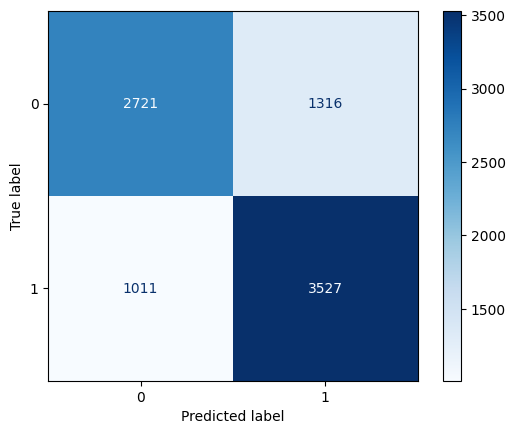

In [17]:
# get predictions from the best model to evaluate
y_pred_probs = nn_model.predict(x_test_scaled)

# convert probabilities to binary predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
y_pred_classes

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d', cmap='Blues')

In [18]:
# look at classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      4037
           1       0.73      0.78      0.75      4538

    accuracy                           0.73      8575
   macro avg       0.73      0.73      0.73      8575
weighted avg       0.73      0.73      0.73      8575



## Save Model
---

In [19]:
# save model
nn_model.save('base_AlphabetSoupCharity.keras')

In [20]:
# reload fresh keras model
model = load_model('base_AlphabetSoupCharity.keras')

# show model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │           185 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575 (2.25 KB)

 Trainable params: 191 (764.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 384 (1.50 KB)